In [1]:
### for 80mpc box
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.interpolate as interp
import scipy as sp
import re


In [2]:
def unPackRawFile(raw_path):
    """
    - unpacks the Raw conditions file. Not used for the neural network.
    """
    y = np.loadtxt(raw_path, skiprows=6)
    distance = y[:,0]
    pec_vel = y[:,1]
    temp = y[:,2]
    HI_density = y[:,3]
    gas_density = y[:,4]
    gas_metallicity = y[:,5]
    
    return distance, pec_vel, temp, HI_density, gas_density, gas_metallicity
def getPos(path_LOS,linenumber=7):
    """
    the start position of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr

def getDir(path_LOS,linenumber=7):
    """
    the direction of the LOS is given inside each file, (in the comments)
    this function parses the comments to get that information
    """
    f = open(path_LOS)
    x = f.readlines()[linenumber]
    answer = re.search('\(([^)]+)', x.split(', ')[1]).group(1)
    arr = np.array(answer.split(','),dtype=float)
    return arr


def convertSphereToCart(theta, phi):
    "converts a unit vector in spherical to cartesian, needed for getGalaxies"
    return np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

In [3]:
##return the distance in extended instead
def lyman_identification():
    """
    function for identifying lls using neutral fraction as filter
    """
    neutral_fraction_limit = 1e-3
    data = []
    for i in range(1000):
        raw_path = 'los.00' + '{0:03}'.format(i) +'.raw'
        distance, pec_vel, temp, HI_density, gas_density, gas_metallicity = unPackRawFile(raw_path)
        #changing the distance from chimp to cmeters
        distance_cm = distance*0.1474*3.086e24 /0.68
        neutral_fraction = HI_density/gas_density
        position = getPos(raw_path)
        direction = convertSphereToCart(getDir(raw_path)[0],getDir(raw_path)[1])
        for k in range(len(distance) -2):
            if((neutral_fraction[k]<neutral_fraction_limit and neutral_fraction[k+1]<neutral_fraction_limit)):
                peak_distance = distance[k]
                real_distance = [(position[0]/256*80 + direction[0]*peak_distance)%80,(position[1]/256*80 + direction[1]*peak_distance)%80,(position[2]/256*80 + direction[2]*peak_distance)%80]
                data.append(real_distance)
    return data
not_lyman_limited_value = lyman_identification()

In [4]:
len(not_lyman_limited_value)

11073985

In [59]:
sliced = []
for i in range(0,len(not_lyman_limited_value),5000):
    sliced.append(not_lyman_limited_value[i])

In [65]:
len(sliced)

2215

In [66]:
gals = np.loadtxt('hprops.res', usecols=[5,6,7],unpack=1) 

In [67]:
points = []
for i,j,k in zip(gals[0],gals[1],gals[2]):
    points.append([i,j,k])
for z in sliced:
    points.append(z)

In [68]:
from sklearn.neighbors import KDTree

In [88]:
def nns(points,lyman_limited_value,k_points):
    tree = KDTree(points)
    #all_nn_indices = tree.query_radius(points, r = 1)
    nearest_dist, all_nn_indices = tree.query(points, k=k_points)
    nns = []
    for i in range(len(all_nn_indices)-len(lyman_limited_value),len(all_nn_indices)):
        nns.append(all_nn_indices[i])
    all_nns = [
        [points[idx] for idx in nn_indices if idx != int(i+len(all_nn_indices)-len(lyman_limited_value))]
        for i, nn_indices in enumerate(nns)
    ]
    neighbors = []
    for nns in all_nns:
        neighbors.append(nns)
    all_distance_diff = []
    temp_distance = []
    for i,k in zip(neighbors,lyman_limited_value):
        all_distance_diff.append(temp_distance)
        temp_distance = []
        for ii in i:
                temp_distance.append(np.sqrt((ii[0]-k[0])**2+(ii[1]-k[1])**2+(ii[2]-k[2])**2))
    plot_data  = []
    for i in all_distance_diff:
        for k in i:
            plot_data.append(k)
    counts,bins = np.histogram(plot_data,bins=50)
    total = np.sum(counts)
    probability = []
    for i in range(len(counts)):
        probability.append(counts[i]/total)
    cumulative_probability = []
    cumulative_probability.append(probability[0])
    for i in range(1,len(probability)):
        cumulative_probability.append(probability[i]+cumulative_probability[i-1])
    cumulative_probability
    return cumulative_probability,counts,bins

/tmp/ipykernel_22769/2406489031.py:4: RuntimeWarning: invalid value encountered in log10
  y2 = np.log10(np.subtract(1,cumulative_probability))
/tmp/ipykernel_22769/2406489031.py:12: RuntimeWarning: divide by zero encountered in log10
  y2 = np.log10(np.subtract(1,cumulative_probability))
/tmp/ipykernel_22769/2406489031.py:28: RuntimeWarning: invalid value encountered in log10
  y2 = np.log10(np.subtract(1,cumulative_probability))


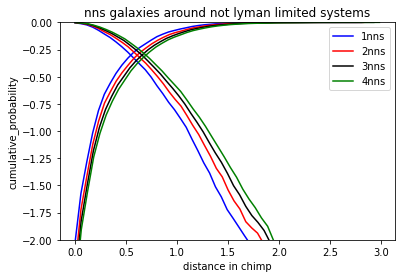

In [89]:
#iterate through each lls instead not includng other stuff
cumulative_probability,counts,bins = nns(points,sliced,2)
y = np.log10(cumulative_probability)
y2 = np.log10(np.subtract(1,cumulative_probability))
x = np.linspace(0,bins[-1] ,50)
plt.plot(x,y,label = str(2-1)+"nns",c="blue")
plt.plot(x,y2,c="blue")
plt.ylim(-2,0)
plt.legend()
cumulative_probability,counts,bins = nns(points,sliced,3)
y = np.log10(cumulative_probability)
y2 = np.log10(np.subtract(1,cumulative_probability))
x = np.linspace(0,bins[-1] ,50)
plt.plot(x,y,label = str(3-1)+"nns",c="red")
plt.plot(x,y2,c="red")
plt.ylim(-2,0)
plt.legend()
cumulative_probability,counts,bins = nns(points,sliced,4)
y = np.log10(cumulative_probability)
y2 = np.log10(np.subtract(1,cumulative_probability))
x = np.linspace(0,bins[-1] ,50)
plt.plot(x,y,label = str(4-1)+"nns",c="black")
plt.plot(x,y2,c="black")
plt.ylim(-2,0)
plt.legend()
cumulative_probability,counts,bins = nns(points,sliced,5)
y = np.log10(cumulative_probability)
y2 = np.log10(np.subtract(1,cumulative_probability))
x = np.linspace(0,bins[-1] ,50)
plt.plot(x,y,label = str(5-1)+"nns",c="green")
plt.plot(x,y2,c="green")
plt.title("nns galaxies around not lyman limited systems")
plt.ylabel("cumulative_probability")
plt.xlabel("distance in chimp")
plt.ylim(-2,0)
plt.legend()
plt.savefig("nns_not_lls.png")

In [90]:
plt.savefig("nns_not_lls.png")

<Figure size 432x288 with 0 Axes>

In [91]:
cumulative_probability,probability,counts,bins = nns(points,sliced,2)


ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
probability

[0.022131887985546522,
 0.04652213188798555,
 0.08581752484191509,
 0.0966576332429991,
 0.1102077687443541,
 0.10569105691056911,
 0.0989159891598916,
 0.08762420957542909,
 0.08536585365853659,
 0.06729900632339657,
 0.04742547425474255,
 0.037940379403794036,
 0.036133694670280034,
 0.023486901535682024,
 0.018066847335140017,
 0.009485094850948509,
 0.006323396567299007,
 0.0040650406504065045,
 0.0018066847335140017,
 0.004516711833785004,
 0.002258355916892502,
 0.00045167118337850043,
 0.0,
 0.00045167118337850043,
 0.0009033423667570009,
 0.0,
 0.0,
 0.0,
 0.0,
 0.00045167118337850043]